# MNIST with PyTorch

In [1]:
from mnist import *
from viz import *

import torch
from torch.nn import Sequential, Module, CrossEntropyLoss
from torch.nn.functional import normalize
import numpy as np


from neurophox.torch import RMTorch
from scipy.stats import unitary_group
from tqdm import tqdm_notebook as pbar

import matplotlib.pyplot as plt
%matplotlib inline
# comment out the below two lines if you have trouble getting the plots to work
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

def rc_mul(real: torch.Tensor, comp: torch.Tensor):
    return real.unsqueeze(dim=0) * comp


def cc_mul(comp1: torch.Tensor, comp2: torch.Tensor) -> torch.Tensor:
    real = comp1[0] * comp2[0] - comp1[1] * comp2[1]
    comp = comp1[0] * comp2[1] + comp1[1] * comp2[0]
    return torch.stack((real, comp), dim=0)

def phasor(real: torch.Tensor):
    return torch.stack((real.cos(), real.sin()), dim=0)


def cnorm(comp: torch.Tensor):
    return (comp[0] ** 2 + comp[1] ** 2).sqrt()


def cnormsq(comp: torch.Tensor):
    return comp[0] ** 2 + comp[1] ** 2


def to_complex_t(nparray: np.ndarray):
    return torch.stack((torch.as_tensor(nparray.real),
                        torch.as_tensor(nparray.imag)), dim=0)


class ElectroopticNonlinearity(Module):
    def __init__(self, alpha: float=0.1, g: float=0.05 * np.pi, phi_b: float=np.pi):
        super(ElectroopticNonlinearity, self).__init__()
        self.alpha = alpha
        self.g = g
        self.phi_b = phi_b

    def forward(self, inputs):
        phase = 0.5 * self.g * cnormsq(inputs) + 0.5 * self.phi_b
        return np.sqrt(1 - self.alpha) * cc_mul(rc_mul(phase.cos(), phasor(-phase)), inputs)


class CNormSq(Module):
    def __init__(self, normed=True):
        super(CNormSq, self).__init__()
        self.normed = normed

    def forward(self, inputs):
        return normalize(cnormsq(inputs), dim=1) if self.normed else cnormsq(inputs)

## Photonic Neural Network Simulation on MNIST

Here, we show how a photonic neural network could conceivably be programmed to solve MNIST using PyTorch (instead of Tensorflow) as the training module. Note that the training is still considerably slower since PyTorch does not yet support complex numbers and CUDA with complex numbers.

In [2]:
mnist_dp = MNISTDataProcessor()
data_N64 = mnist_dp.fourier(4)

In [ ]:
mnist_model = Sequential(
    RMTorch(64),
    ElectroopticNonlinearity(),
    RMTorch(64),
    ElectroopticNonlinearity(),
    CNormSq()
).cuda()

criterion = torch.nn.MSELoss(reduction='mean').cuda()
optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3)
n_epochs = 200
n_split = 100 # batch size is 60000 / n_split
test_losses = []
accuracies = []

for epoch in range(n_epochs):
    out = mnist_model(data_N64.x_test.astype(np.complex64))[:, :10]
    target_ind = torch.tensor(data_N64.y_test_ind, dtype=torch.long).cuda()
    target = torch.tensor(data_N64.y_test.astype(np.float32)).cuda()
    accuracy = (out.argmax(dim=1) == target_ind).sum().type(torch.DoubleTensor) / data_N64.y_test.shape[0]
    test_losses.append(criterion(out, target).item())
    accuracies.append(accuracy.item())
    print(f'Epoch {epoch} - Test loss: {test_loss.item()} - Accuracy: {accuracy.item()}')
    iterator = pbar(list(zip(np.split(data_N64.x_train, n_split), np.split(data_N64.y_train, n_split))))
    for x, y in iterator:
        loss = criterion(mnist_model(x.astype(np.complex64))[:, :10],
                         torch.tensor(y.astype(np.float32)).cuda())
        optimizer.zero_grad()
        loss.backward()
        iterator.set_description(f"𝓛: {loss:.5f}")
        optimizer.step()

Epoch 0 - Test loss: 0.10705986618995667 - Accuracy: 0.04580000042915344



Epoch 1 - Test loss: 0.028666293248534203 - Accuracy: 0.7889999747276306



Epoch 2 - Test loss: 0.015737444162368774 - Accuracy: 0.9046000242233276



Epoch 3 - Test loss: 0.012482340447604656 - Accuracy: 0.9241999983787537



Epoch 4 - Test loss: 0.011047275736927986 - Accuracy: 0.9329000115394592



Epoch 5 - Test loss: 0.010157661512494087 - Accuracy: 0.9375



Epoch 6 - Test loss: 0.009546278044581413 - Accuracy: 0.9412000179290771



Epoch 7 - Test loss: 0.009074988774955273 - Accuracy: 0.9452999830245972



Epoch 8 - Test loss: 0.008690756745636463 - Accuracy: 0.9466000199317932



Epoch 9 - Test loss: 0.008369171991944313 - Accuracy: 0.9474999904632568



Epoch 10 - Test loss: 0.008095827884972095 - Accuracy: 0.9491000175476074



Epoch 11 - Test loss: 0.00786092784255743 - Accuracy: 0.9514999985694885



Epoch 12 - Test loss: 0.007655573543161154 - Accuracy: 0.9534000158309937



Epoch 13 - Test loss: 0.007472817320376635 - Accuracy: 0.9542999863624573



Epoch 14 - Test loss: 0.0073079271242022514 - Accuracy: 0.9552000164985657



Epoch 15 - Test loss: 0.007157647050917149 - Accuracy: 0.9569000005722046



Epoch 16 - Test loss: 0.007019600830972195 - Accuracy: 0.9581000208854675



Epoch 17 - Test loss: 0.006892201490700245 - Accuracy: 0.9587000012397766



Epoch 18 - Test loss: 0.0067744068801403046 - Accuracy: 0.960099995136261



Epoch 19 - Test loss: 0.006665509194135666 - Accuracy: 0.9606000185012817



Epoch 20 - Test loss: 0.0065649827010929585 - Accuracy: 0.9614999890327454



Epoch 21 - Test loss: 0.006472407374531031 - Accuracy: 0.9628000259399414



Epoch 22 - Test loss: 0.0063873399049043655 - Accuracy: 0.9625999927520752



Epoch 23 - Test loss: 0.006309185177087784 - Accuracy: 0.9635999798774719



Epoch 24 - Test loss: 0.006237191613763571 - Accuracy: 0.9641000032424927



Epoch 25 - Test loss: 0.006170608103275299 - Accuracy: 0.9646999835968018



Epoch 26 - Test loss: 0.0061088306829333305 - Accuracy: 0.9646999835968018



Epoch 27 - Test loss: 0.0060513317584991455 - Accuracy: 0.964900016784668



Epoch 28 - Test loss: 0.005997633095830679 - Accuracy: 0.965399980545044



Epoch 29 - Test loss: 0.005947180092334747 - Accuracy: 0.9656999707221985



Epoch 30 - Test loss: 0.005899501498788595 - Accuracy: 0.9659000039100647



Epoch 31 - Test loss: 0.005854197312146425 - Accuracy: 0.9663000106811523



Epoch 32 - Test loss: 0.005810983944684267 - Accuracy: 0.9668999910354614



Epoch 33 - Test loss: 0.005769594572484493 - Accuracy: 0.9671000242233276



Epoch 34 - Test loss: 0.005729775410145521 - Accuracy: 0.9672999978065491



Epoch 35 - Test loss: 0.005691318307071924 - Accuracy: 0.9672999978065491



Epoch 36 - Test loss: 0.0056540281511843204 - Accuracy: 0.9674000144004822



Epoch 37 - Test loss: 0.00561780808493495 - Accuracy: 0.9675999879837036



Epoch 38 - Test loss: 0.005582620855420828 - Accuracy: 0.9682000279426575



Epoch 39 - Test loss: 0.005548493470996618 - Accuracy: 0.9684000015258789



Epoch 40 - Test loss: 0.005515521392226219 - Accuracy: 0.9685999751091003



Epoch 41 - Test loss: 0.005483769346028566 - Accuracy: 0.9684000015258789



Epoch 42 - Test loss: 0.005453258287161589 - Accuracy: 0.968500018119812



Epoch 43 - Test loss: 0.005424011033028364 - Accuracy: 0.968999981880188



Epoch 44 - Test loss: 0.005396042950451374 - Accuracy: 0.9695000052452087



Epoch 45 - Test loss: 0.005369420628994703 - Accuracy: 0.9696999788284302



Epoch 46 - Test loss: 0.005344200413674116 - Accuracy: 0.9696999788284302



Epoch 47 - Test loss: 0.0053203534334897995 - Accuracy: 0.9695000052452087



Epoch 48 - Test loss: 0.00529777817428112 - Accuracy: 0.9696000218391418



Epoch 49 - Test loss: 0.0052763535641133785 - Accuracy: 0.9696000218391418



Epoch 50 - Test loss: 0.005255953408777714 - Accuracy: 0.9697999954223633



Epoch 51 - Test loss: 0.005236464086920023 - Accuracy: 0.9700999855995178



Epoch 52 - Test loss: 0.005217800382524729 - Accuracy: 0.9700999855995178



Epoch 53 - Test loss: 0.00519990362226963 - Accuracy: 0.970300018787384



Epoch 54 - Test loss: 0.0051827095448970795 - Accuracy: 0.9706000089645386



Epoch 55 - Test loss: 0.00516614131629467 - Accuracy: 0.9704999923706055



Epoch 56 - Test loss: 0.00515018543228507 - Accuracy: 0.9704999923706055



Epoch 57 - Test loss: 0.0051347846165299416 - Accuracy: 0.9707000255584717



Epoch 58 - Test loss: 0.005119901616126299 - Accuracy: 0.9706000089645386



Epoch 59 - Test loss: 0.005105502903461456 - Accuracy: 0.9704999923706055



Epoch 60 - Test loss: 0.005091518629342318 - Accuracy: 0.9707000255584717



Epoch 61 - Test loss: 0.0050779059529304504 - Accuracy: 0.97079998254776



Epoch 62 - Test loss: 0.005064621102064848 - Accuracy: 0.9708999991416931



Epoch 63 - Test loss: 0.005051635671406984 - Accuracy: 0.9710000157356262



Epoch 64 - Test loss: 0.005038938019424677 - Accuracy: 0.9710000157356262



Epoch 65 - Test loss: 0.005026529543101788 - Accuracy: 0.9710000157356262



Epoch 66 - Test loss: 0.00501442002132535 - Accuracy: 0.9710999727249146



Epoch 67 - Test loss: 0.005002612713724375 - Accuracy: 0.9710999727249146



Epoch 68 - Test loss: 0.004991123452782631 - Accuracy: 0.9710000157356262



Epoch 69 - Test loss: 0.0049799708649516106 - Accuracy: 0.9708999991416931



Epoch 70 - Test loss: 0.0049691591411828995 - Accuracy: 0.9710999727249146



Epoch 71 - Test loss: 0.00495867757126689 - Accuracy: 0.9713000059127808



Epoch 72 - Test loss: 0.004948532674461603 - Accuracy: 0.9714000225067139



Epoch 73 - Test loss: 0.004938704427331686 - Accuracy: 0.9714999794960022



Epoch 74 - Test loss: 0.004929172806441784 - Accuracy: 0.9717000126838684



Epoch 75 - Test loss: 0.004919902421534061 - Accuracy: 0.9717000126838684



Epoch 76 - Test loss: 0.004910878371447325 - Accuracy: 0.9717000126838684



Epoch 77 - Test loss: 0.004902082495391369 - Accuracy: 0.9711999893188477



Epoch 78 - Test loss: 0.00489348778501153 - Accuracy: 0.9714999794960022



Epoch 79 - Test loss: 0.004885077476501465 - Accuracy: 0.9715999960899353



Epoch 80 - Test loss: 0.004876843653619289 - Accuracy: 0.9715999960899353



Epoch 81 - Test loss: 0.004868770018219948 - Accuracy: 0.9717000126838684



Epoch 82 - Test loss: 0.004860863089561462 - Accuracy: 0.9717000126838684



Epoch 83 - Test loss: 0.004853109363466501 - Accuracy: 0.9715999960899353



Epoch 84 - Test loss: 0.00484549580141902 - Accuracy: 0.9714999794960022



Epoch 85 - Test loss: 0.004838028457015753 - Accuracy: 0.9715999960899353



Epoch 86 - Test loss: 0.004830693360418081 - Accuracy: 0.9715999960899353



Epoch 87 - Test loss: 0.0048234849236905575 - Accuracy: 0.9718999862670898



Epoch 88 - Test loss: 0.004816398024559021 - Accuracy: 0.972100019454956



Epoch 89 - Test loss: 0.004809410311281681 - Accuracy: 0.972000002861023



Epoch 90 - Test loss: 0.004802532494068146 - Accuracy: 0.972100019454956



Epoch 91 - Test loss: 0.0047957380302250385 - Accuracy: 0.9724000096321106



Epoch 92 - Test loss: 0.004789031110703945 - Accuracy: 0.9725000262260437



Epoch 93 - Test loss: 0.0047824024222791195 - Accuracy: 0.9722999930381775



Epoch 94 - Test loss: 0.0047758412547409534 - Accuracy: 0.9721999764442444



Epoch 95 - Test loss: 0.004769350402057171 - Accuracy: 0.9722999930381775



Epoch 96 - Test loss: 0.004762928932905197 - Accuracy: 0.9718999862670898



Epoch 97 - Test loss: 0.004756583832204342 - Accuracy: 0.9718999862670898



Epoch 98 - Test loss: 0.004750325810164213 - Accuracy: 0.9718000292778015



Epoch 99 - Test loss: 0.004744134843349457 - Accuracy: 0.972000002861023



Epoch 100 - Test loss: 0.0047380393370985985 - Accuracy: 0.972000002861023



Epoch 101 - Test loss: 0.004732017405331135 - Accuracy: 0.972000002861023



Epoch 102 - Test loss: 0.004726087674498558 - Accuracy: 0.972100019454956



Epoch 103 - Test loss: 0.004720241297036409 - Accuracy: 0.9721999764442444



Epoch 104 - Test loss: 0.004714481066912413 - Accuracy: 0.9721999764442444



Epoch 105 - Test loss: 0.004708795342594385 - Accuracy: 0.9721999764442444



Epoch 106 - Test loss: 0.004703182261437178 - Accuracy: 0.9721999764442444



Epoch 107 - Test loss: 0.004697632975876331 - Accuracy: 0.9721999764442444



Epoch 108 - Test loss: 0.004692145623266697 - Accuracy: 0.9721999764442444



Epoch 109 - Test loss: 0.0046867080964148045 - Accuracy: 0.9722999930381775



Epoch 110 - Test loss: 0.004681306425482035 - Accuracy: 0.9724000096321106



Epoch 111 - Test loss: 0.004675941076129675 - Accuracy: 0.9726999998092651



Epoch 112 - Test loss: 0.0046705929562449455 - Accuracy: 0.9726999998092651



Epoch 113 - Test loss: 0.004665254149585962 - Accuracy: 0.9726999998092651



Epoch 114 - Test loss: 0.004659926053136587 - Accuracy: 0.9728000164031982



Epoch 115 - Test loss: 0.004654583986848593 - Accuracy: 0.9726999998092651



Epoch 116 - Test loss: 0.004649236798286438 - Accuracy: 0.9726999998092651



Epoch 117 - Test loss: 0.0046438779681921005 - Accuracy: 0.9726999998092651



Epoch 118 - Test loss: 0.004638506565243006 - Accuracy: 0.9728999733924866



Epoch 119 - Test loss: 0.004633117932826281 - Accuracy: 0.9729999899864197



Epoch 120 - Test loss: 0.0046277171932160854 - Accuracy: 0.9728000164031982



Epoch 121 - Test loss: 0.0046223001554608345 - Accuracy: 0.9728000164031982



Epoch 122 - Test loss: 0.004616882186383009 - Accuracy: 0.9728999733924866



Epoch 123 - Test loss: 0.004611461888998747 - Accuracy: 0.9731000065803528



Epoch 124 - Test loss: 0.004606053698807955 - Accuracy: 0.9731000065803528



Epoch 125 - Test loss: 0.004600659944117069 - Accuracy: 0.9731000065803528



Epoch 126 - Test loss: 0.004595298320055008 - Accuracy: 0.9731000065803528



Epoch 127 - Test loss: 0.00458997068926692 - Accuracy: 0.9732999801635742



Epoch 128 - Test loss: 0.004584683105349541 - Accuracy: 0.9733999967575073



Epoch 129 - Test loss: 0.004579456523060799 - Accuracy: 0.9735000133514404



Epoch 130 - Test loss: 0.004574296530336142 - Accuracy: 0.9735999703407288



Epoch 131 - Test loss: 0.0045692031271755695 - Accuracy: 0.973800003528595



Epoch 132 - Test loss: 0.004564187023788691 - Accuracy: 0.973800003528595



Epoch 133 - Test loss: 0.0045592570677399635 - Accuracy: 0.9736999869346619



Epoch 134 - Test loss: 0.004554415121674538 - Accuracy: 0.973800003528595



Epoch 135 - Test loss: 0.0045496695674955845 - Accuracy: 0.9739000201225281



Epoch 136 - Test loss: 0.004545014817267656 - Accuracy: 0.9739000201225281



Epoch 137 - Test loss: 0.004540454130619764 - Accuracy: 0.973800003528595



Epoch 138 - Test loss: 0.004535991698503494 - Accuracy: 0.9739000201225281



Epoch 139 - Test loss: 0.0045316400937736034 - Accuracy: 0.9739000201225281



Epoch 140 - Test loss: 0.0045273820869624615 - Accuracy: 0.9739000201225281



Epoch 141 - Test loss: 0.004523233976215124 - Accuracy: 0.9740999937057495



Epoch 142 - Test loss: 0.004519173409789801 - Accuracy: 0.9740999937057495



Epoch 143 - Test loss: 0.004515223205089569 - Accuracy: 0.9739999771118164



Epoch 144 - Test loss: 0.004511367995291948 - Accuracy: 0.9740999937057495



Epoch 145 - Test loss: 0.0045076091773808 - Accuracy: 0.9742000102996826



Epoch 146 - Test loss: 0.004503930453211069 - Accuracy: 0.9743000268936157



Epoch 147 - Test loss: 0.004500335548073053 - Accuracy: 0.974399983882904



Epoch 148 - Test loss: 0.00449680769816041 - Accuracy: 0.9746000170707703



Epoch 149 - Test loss: 0.004493345972150564 - Accuracy: 0.9746999740600586



Epoch 150 - Test loss: 0.004489932209253311 - Accuracy: 0.9746999740600586



Epoch 151 - Test loss: 0.004486562684178352 - Accuracy: 0.9746999740600586



Epoch 152 - Test loss: 0.004483235068619251 - Accuracy: 0.9746999740600586



Epoch 153 - Test loss: 0.0044799321331083775 - Accuracy: 0.9746999740600586



Epoch 154 - Test loss: 0.004476653877645731 - Accuracy: 0.9746999740600586



Epoch 155 - Test loss: 0.004473390057682991 - Accuracy: 0.9745000004768372



Epoch 156 - Test loss: 0.0044701434671878815 - Accuracy: 0.9745000004768372



Epoch 157 - Test loss: 0.00446690758690238 - Accuracy: 0.9747999906539917



Epoch 158 - Test loss: 0.00446366798132658 - Accuracy: 0.9747999906539917



Epoch 159 - Test loss: 0.004460424184799194 - Accuracy: 0.9747999906539917



Epoch 160 - Test loss: 0.004457174800336361 - Accuracy: 0.9747999906539917



Epoch 161 - Test loss: 0.0044539007358253 - Accuracy: 0.9746999740600586



Epoch 162 - Test loss: 0.004450611770153046 - Accuracy: 0.9747999906539917



Epoch 163 - Test loss: 0.00444730743765831 - Accuracy: 0.9746999740600586



Epoch 164 - Test loss: 0.0044439989142119884 - Accuracy: 0.9746999740600586



Epoch 165 - Test loss: 0.004440682474523783 - Accuracy: 0.9746999740600586



Epoch 166 - Test loss: 0.004437367431819439 - Accuracy: 0.9746000170707703



Epoch 167 - Test loss: 0.004434064496308565 - Accuracy: 0.9745000004768372



Epoch 168 - Test loss: 0.004430774133652449 - Accuracy: 0.974399983882904



Epoch 169 - Test loss: 0.004427507519721985 - Accuracy: 0.974399983882904



Epoch 170 - Test loss: 0.004424251616001129 - Accuracy: 0.9746999740600586



Epoch 171 - Test loss: 0.004421028308570385 - Accuracy: 0.9747999906539917



Epoch 172 - Test loss: 0.00441782409325242 - Accuracy: 0.9750000238418579



Epoch 173 - Test loss: 0.004414638504385948 - Accuracy: 0.9747999906539917



Epoch 174 - Test loss: 0.00441147992387414 - Accuracy: 0.9746999740600586



Epoch 175 - Test loss: 0.00440834229812026 - Accuracy: 0.9746999740600586



Epoch 176 - Test loss: 0.004405218642205 - Accuracy: 0.9749000072479248



Epoch 177 - Test loss: 0.0044021219946444035 - Accuracy: 0.9749000072479248



Epoch 178 - Test loss: 0.0043990397825837135 - Accuracy: 0.9749000072479248



Epoch 179 - Test loss: 0.0043959724716842175 - Accuracy: 0.9750000238418579



Epoch 180 - Test loss: 0.004392925184220076 - Accuracy: 0.9750000238418579



Epoch 181 - Test loss: 0.004389888606965542 - Accuracy: 0.9750999808311462



Epoch 182 - Test loss: 0.004386865068227053 - Accuracy: 0.9750000238418579



Epoch 183 - Test loss: 0.004383851774036884 - Accuracy: 0.9750000238418579



Epoch 184 - Test loss: 0.004380851052701473 - Accuracy: 0.9750000238418579



Epoch 185 - Test loss: 0.004377847071737051 - Accuracy: 0.9750000238418579



Epoch 186 - Test loss: 0.004374864976853132 - Accuracy: 0.9749000072479248



Epoch 187 - Test loss: 0.00437189033254981 - Accuracy: 0.9747999906539917



Epoch 188 - Test loss: 0.004368925932794809 - Accuracy: 0.9747999906539917



Epoch 189 - Test loss: 0.004365964792668819 - Accuracy: 0.9747999906539917



Epoch 190 - Test loss: 0.004363019950687885 - Accuracy: 0.9749000072479248


Text(0.5, 1.0, 'Torch-MNIST Learning Curve')

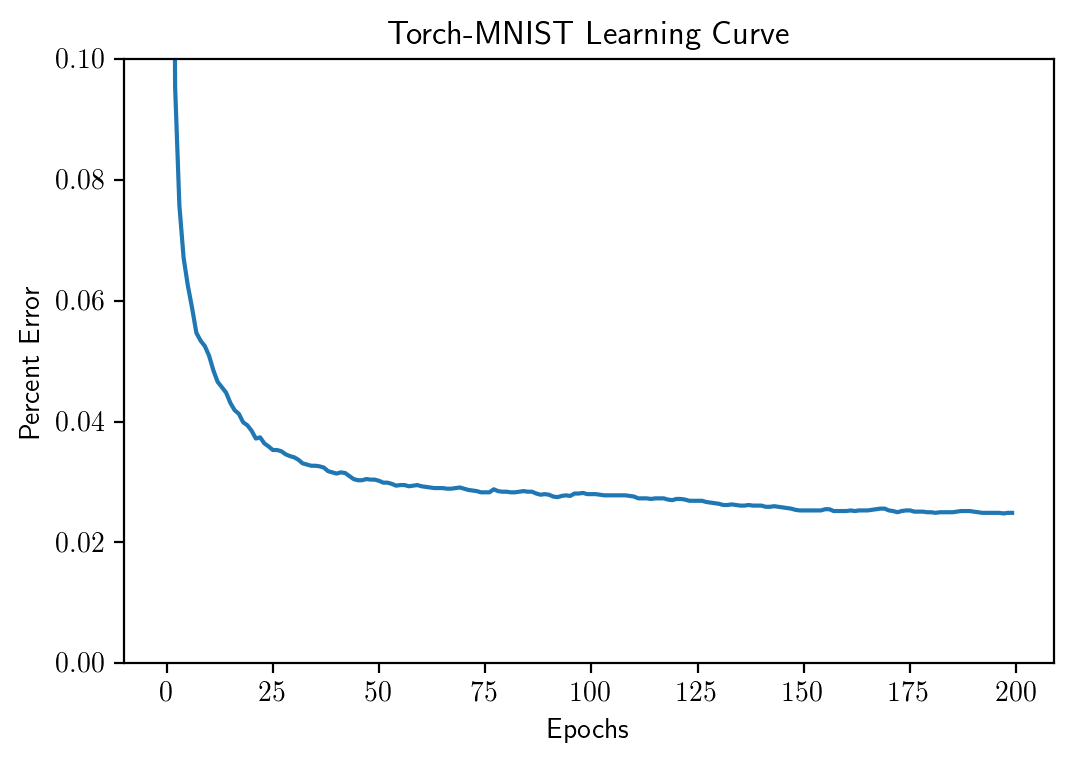

In [20]:
plt.figure(dpi=200)
plt.plot(1 - np.asarray(accuracies))
plt.ylabel('Percent Error')
plt.xlabel('Epochs')
plt.ylim((0, 0.1))
plt.title('Torch-MNIST Learning Curve')

## Matrix Optimization with PyTorch

Here, we demonstrate optimizing a rectangular mesh layer optimizing a random $128 \times 128$ unitary matrix.

In [18]:
N = 128
layer = RMTorch(N).cuda()
target = to_complex_t(unitary_group.rvs(N)).cuda()
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(layer.parameters(), lr=5e-3)
n_iterations = 1000
loss_history = []
for t in pbar(range(n_iterations)):
    loss = criterion(layer(np.eye(N)), target) / (2 * N)
    optimizer.zero_grad()
    loss.backward()
    loss_history.append(loss.item())
    iterator.set_description(f"𝓛: {loss:.5f}")
    optimizer.step()

Text(0, 0.5, 'MSE Loss')

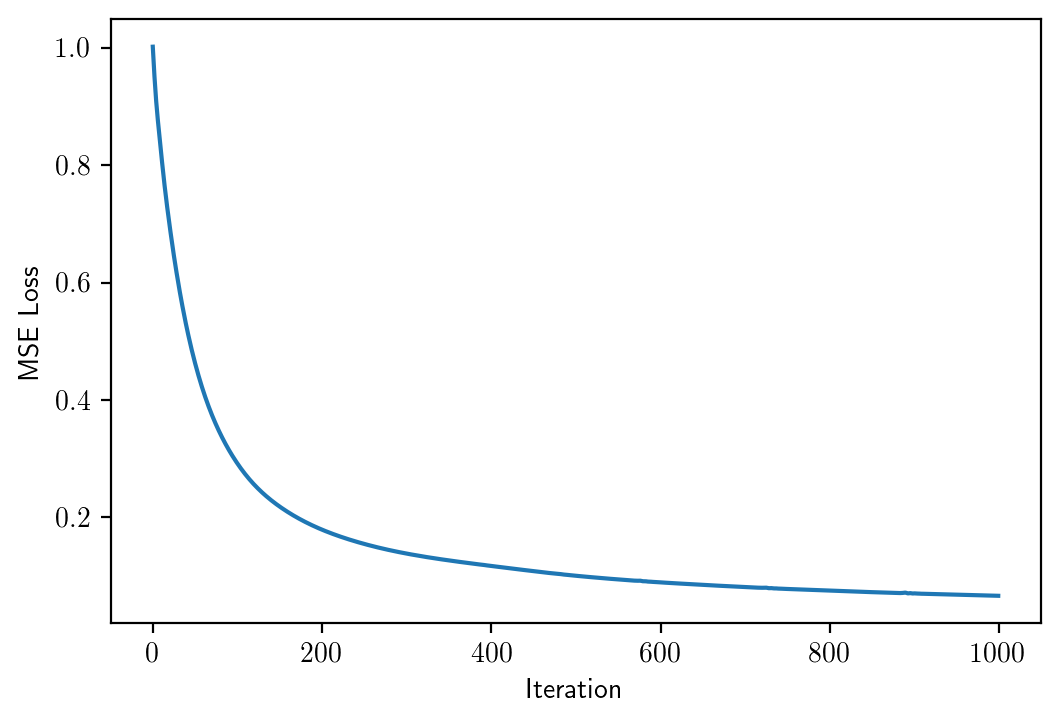

In [21]:
plt.figure(dpi=200)
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')